In [1]:
import pandas as pd
import pyranges as pr

def coord_to_region_names(coord):
    """
    PyRanges to region names
    """
    if isinstance(coord, pr.PyRanges):
        coord = coord.as_df()
        return list('ID-' + coord['Chromosome'].astype(str) + '-' + coord['Start'].astype(str) + '-' + coord['End'].astype(str))

file_path = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/SNARE_human/r2g.importance.bed'
pd_df_for_liftover = pd.read_csv(file_path, sep='\t', skiprows=1, header=None)
pd_df_for_liftover = pd_df_for_liftover.iloc[:,0:4]
pd_df_for_liftover.columns = ['Chromosome', 'Start', 'End', 'Name']
pd_df_for_liftover['Name'] = list('ID-' + pd_df_for_liftover['Chromosome'].astype(str) + '-' + pd_df_for_liftover['Start'].astype(str) + '-' + pd_df_for_liftover['End'].astype(str))
pd_df_for_liftover.to_csv('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/SNARE_human/r2g.importance.forliftover.bed', sep='\t', header=None, index=None)
# for links
# 196819 good
# 57141 failed
# for eregulon
# 101291 good
# 24740 failed

#### For SNARE-seq

In [2]:
import pandas as pd
import pyranges as pr
file_path = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/SNARE_human/liftover_results.bed'
assignments = pd.read_csv(file_path, sep='\t', header=None)
assignments.columns = ['Chromosome', 'Start', 'End', 'Name_hg']
assignments['Name_mm'] = list('ID-' + assignments['Chromosome'].astype(str) + '-' + assignments['Start'].astype(str) + '-' + assignments['End'].astype(str))
assignments = assignments[['Name_mm', 'Name_hg']]
assignments = assignments.drop_duplicates(subset='Name_hg', keep='first')
zip_iterator = zip(assignments['Name_hg'].tolist(), assignments['Name_mm'].tolist())
assignments = dict(zip_iterator)
file_path = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/SNARE_human/r2g.importance.bed'
links = pd.read_csv(file_path, sep='\t', skiprows=1, header=None)
links.columns = ['Chr_region', 'Start_region', 'End_region', 'Name', 'Score_1', 'Score_2', 'Strand', 'RGB', 'Chr_link', 'Start_link', 'End_link', 'Name_link', 'Strand_link', 'Chr_TSS', 'Start_TSS', 'End_TSS', 'Gene', 'Strand_gene']
links['Name_hg'] = list('ID-' + links['Chr_region'].astype(str) + '-' + links['Start_region'].astype(str) + '-' + links['End_region'].astype(str))
links = links[links['Name_hg'].isin(list(assignments.keys()))]
links['Name_mm'] = [assignments[x] for x in links['Name_hg'].tolist()]
region_names = links['Name_mm']
chrom = [x.split('-')[1] for x in region_names]
start = [int(x.split('-')[2]) for x in region_names]
end = [int(x.split('-')[3]) for x in region_names]
start_link = [y + int((x - y)/2) for x, y in zip(end, start)]
end_link = [x + 1 for x in start_link]
links['Chr_region'] = chrom
links['Start_region'] = start
links['End_region'] = end
links['Start_link'] = start_link
links['End_link'] = end_link
links['Chr_link'] = chrom

In [3]:
# Get TSS annotations
import pybiomart as pbm
dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://www.ensembl.org')
annot = dataset.query(attributes=['external_gene_name', 'mmusculus_homolog_associated_gene_name'])
annot.dropna(axis = 0, how = 'any', inplace = True)
annot_gene = annot
annot_gene.columns = ['Human', 'Gene']
# Get TSS annotations
import pybiomart as pbm
# For mouse (mm39)
#dataset = pbm.Dataset(name='mmusculus_gene_ensembl',  host='http://www.ensembl.org')
# For mouse (mm10)
dataset = pbm.Dataset(name='mmusculus_gene_ensembl',  host='http://may2015.archive.ensembl.org/')
# For human (hg38)
#dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://www.ensembl.org')
# For human (hg19)
#dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://grch37.ensembl.org/')
# For fly (dm6)
# dataset = pbm.Dataset(name='dmelanogaster_gene_ensembl',  host='http://www.ensembl.org')
annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
filter = annot['Chromosome'].str.contains('CHR|GL|JH|MT')
annot = annot[~filter]
annot['Chromosome'] = annot['Chromosome'].str.replace(r'(\b\S)', r'chr\1')
annot = annot[annot.Transcript_type == 'protein_coding']
annot['Name_mm'] = list('ID-' + annot['Chromosome'].astype(str) + '-' + annot['Start'].astype(str) + '-' + (annot['Start']+1).astype(str))
annot = annot[['Name_mm', 'Gene']]
annot = annot.drop_duplicates(subset='Gene')
annot = annot.merge(annot_gene, on='Gene')
annot = annot[['Human', 'Name_mm']]
zip_iterator = zip(annot['Human'].tolist(), annot['Name_mm'].tolist())
annot = dict(zip_iterator)
links = links[links['Gene'].isin(list(annot.keys()))]
links['Name_mm_tss'] = [annot[x] for x in links['Gene'].tolist()]
region_names = links['Name_mm_tss']
chrom = [x.split('-')[1] for x in region_names]
start = [int(x.split('-')[2]) for x in region_names]
end = [int(x.split('-')[3]) for x in region_names]
links['Chr_TSS'] = chrom
links['Start_TSS'] = start
links['End_TSS'] = end

/tmp/ipykernel_7875/2493552424.py:24: FutureWarning: The default value of regex will change from True to False in a future version.
  annot['Chromosome'] = annot['Chromosome'].str.replace(r'(\b\S)', r'chr\1')


In [4]:
links = links.iloc[:, 0:18]
# sort dataframe
links['Chr_region']=links['Chr_region']
links['Start_region']=links['Start_region']
df_interact =  links.sort_values(by=['Chr_region', 'Start_region'])
# Write interact file
with open('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/SNARE_human/human_r2g.importance.bed', 'w') as f:
    df_interact.to_csv(f, header=False, index=False, sep='\t')

In [6]:
links

,Chr_region,Start_region,End_region,Name,Score_1,Score_2,Strand,RGB,Chr_link,Start_link,End_link,Name_link,Strand_link,Chr_TSS,Start_TSS,End_TSS,Gene,Strand_gene
4,chr2,25220317,25220872,KLHL17_1,3,0.003729,.,"237,248,234",chr2,25220594,25220595,KLHL17_1,.,chr4,156234857,156234858,KLHL17,+
5,chr2,25220317,25220872,AGRN_1,2,0.002796,.,"244,250,241",chr2,25220594,25220595,AGRN_1,.,chr4,156185901,156185902,AGRN,+
6,chr2,25220317,25220872,NOC2L_1,1,0.001173,.,"245,251,243",chr2,25220594,25220595,NOC2L_1,.,chr4,156236010,156236011,NOC2L,-
7,chr2,25220317,25220872,ISG15_1,1,0.001017,.,"243,250,241",chr2,25220594,25220595,ISG15_1,.,chr4,156200818,156200819,ISG15,+
34,chr4,156252901,156253122,KLHL17_1,26,0.026408,.,"107,191,113",chr4,156253011,156253012,KLHL17_1,.,chr4,156234857,156234858,KLHL17,+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379726,chrX,94122861,94123365,ZFY_1,93,0.093677,.,"255,245,240",chrX,94123113,94123114,ZFY_1,.,chrX,94123407,94123408,ZFY,+
379728,chrX,94122285,94122814,ZFY_1,96,0.096952,.,"103,0,12",chrX,94122549,94122550,ZFY_1,.,chrX,94123407,94123408,ZFY,+
379735,chrX,13281842,13281967,DDX3Y_1,237,0.237185,.,"255,245,240",chrX,13281904,13281905,DDX3Y_1,.,chrY,1286629,1286630,DDX3Y,+
379736,chrX,13281842,13281967,USP9Y_1,95,0.095920,.,"255,245,240",chrX,13281904,13281905,USP9Y_1,.,chrY,1459782,1459783,USP9Y,+


In [9]:
bedToBigBed -as=interact.as -type=bed5+13 human_r2g.rho.bed mm10.chrom.sizes human_r2g.rho.bb
bedToBigBed -as=interact.as -type=bed5+13 human_r2g.importance.bed mm10.chrom.sizes human_r2g.importance.bb

### Some stats

In [11]:
mouse_coords = pr.read_bed('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/SNARE_mouse/output/atac_bc/scenicplus_v3/eRegulons.bed')
human_coords = pr.read_bed('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/SNARE_human/eregulons/eRegulons_mouse_coordinates.bed')

In [34]:
mouse_tfs = set([x.split('_')[0].upper() for x in mouse_coords.df['Name']])
human_tfs = set([x.split('_')[0].upper() for x in human_coords.df['Name']])
[x for x in mouse_tfs if x in human_tfs]

['KLF8',
 'DLX1',
 'CEBPZ',
 'NFE2L1',
 'RARB',
 'PBX3',
 'ZBTB7A',
 'ETV5',
 'ESRRG',
 'PPARG',
 'FOSB',
 'RFX3',
 'MEF2C',
 'ELF1',
 'ARX',
 'NEUROD2',
 'E2F4',
 'MAF',
 'IRF2',
 'THRA',
 'TCF7L2',
 'CELF4',
 'SMARCC2',
 'STAU2',
 'EGR2',
 'PBX1',
 'TCF4',
 'NFIX',
 'SMAD3',
 'SOX6',
 'NR3C1',
 'NFAT5',
 'MEF2D',
 'MEF2A',
 'RBMS1',
 'THRB',
 'NCALD',
 'KLF9',
 'BCL11A',
 'SOX10',
 'CNOT4',
 'NPDC1',
 'BCL11B',
 'BCLAF1',
 'ZEB1',
 'ETV1',
 'FOS',
 'FOXO3',
 'PKNOX2',
 'RB1',
 'RORA',
 'FOXN3',
 'EGR4',
 'CHD2',
 'FOXP2',
 'PPARGC1A',
 'KLF7',
 'ETV6',
 'KLF15',
 'NFIA',
 'YBX1',
 'TEF',
 'HLF',
 'TRIM28',
 'FLI1',
 'EGR1',
 'KLF12',
 'POU2F1',
 'DNMT3A',
 'BDP1',
 'RFX7',
 'BACH2',
 'CELF5',
 'PKM',
 'RORB',
 'SREBF2',
 'POU6F2',
 'RAD21',
 'CUX1',
 'FOXP1',
 'E2F3',
 'NFIB',
 'TCF12',
 'LHX6',
 'SOX5',
 'POU6F1',
 'MEIS2']

In [12]:
combined = mouse_coords.join(human_coords)

In [13]:
combined=combined.df
combined['Consensus_mm_name'] = [x.split('_')[0].upper() for x in combined['Name']]
combined['Consensus_hg_name'] = [x.split('_')[0].upper() for x in combined['Name_b']]

In [14]:
same_tf=combined[combined['Consensus_mm_name'] == combined['Consensus_hg_name']]

In [21]:
same_tf['Consensus_hg_name'].value_counts()

393

<AxesSubplot:xlabel='Consensus_hg_name', ylabel='count'>

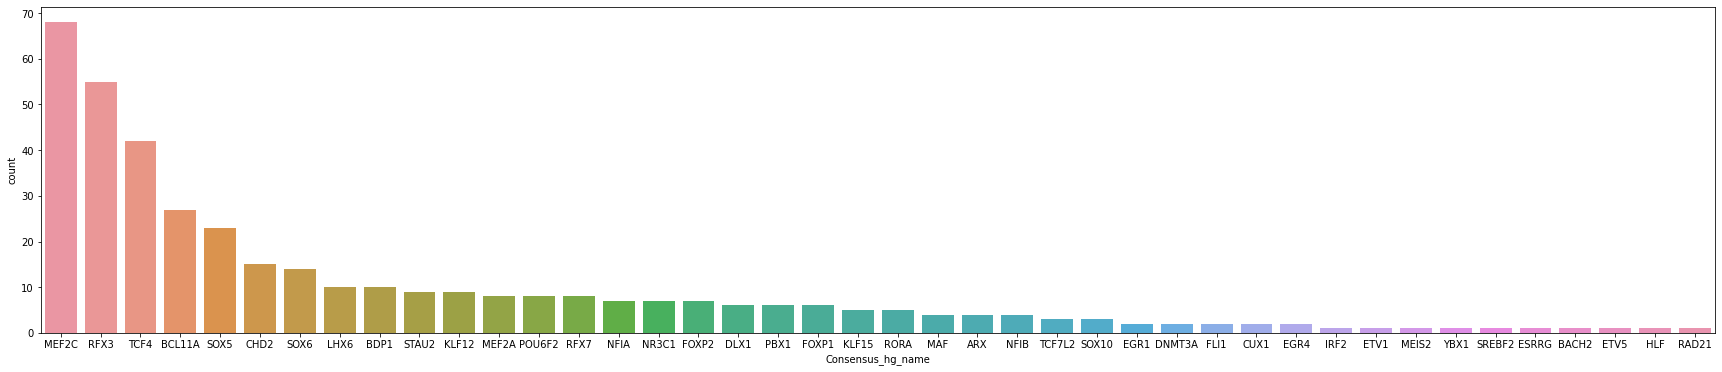

In [24]:
import seaborn
from matplotlib import pyplot
a4_dims = (30, 6)
fig, ax = pyplot.subplots(figsize=a4_dims)
seaborn.countplot(x='Consensus_hg_name', data=same_tf, order=same_tf['Consensus_hg_name'].value_counts().index)

In [18]:
human_coords.df.iloc[:,0:3].drop_duplicates()

,Chromosome,Start,End
0,chr1,173491913,173492103
1,chr1,173460334,173460784
3,chr1,173459864,173460297
10,chr1,173436667,173437133
12,chr1,173388762,173389222
...,...,...,...
101274,chrX,94122285,94122814
101277,chrX,13281842,13281967
101280,chrX,18162905,18163440
101281,chrX_GL456233_random,110877,111240


In [20]:
combined.iloc[:,0:3].drop_duplicates()

,Chromosome,Start,End
0,chr1,3210205,3210705
2,chr1,3309953,3310453
6,chr1,3366355,3366855
9,chr1,3399791,3400291
10,chr1,3406097,3406597
...,...,...,...
11597,chrX,160585181,160585681
11598,chrX,160993817,160994317
11600,chrX,161909251,161909751
11601,chrX,166225450,166225950


#### For In-house

### Some stats

In [38]:
mouse_coords = pr.read_bed('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_direct_ortho/eRegulons.bed')
human_coords = pr.read_bed('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/SNARE_human/eregulons/eRegulons_mouse_coordinates.bed')

In [40]:
mouse_tfs = set([x.split('_')[0].upper() for x in mouse_coords.df['Name']])
human_tfs = set([x.split('_')[0].upper() for x in human_coords.df['Name']])
len([x for x in mouse_tfs if x in human_tfs])

118

In [41]:
combined = mouse_coords.join(human_coords)

In [46]:
combined

,Chromosome,Start,End,Name,Start_b,End_b,Name_b,Consensus_mm_name,Consensus_hg_name
0,chr1,5017896,5018396,Rfx3_+_+,5018238,5018683,CUX1_+_+,RFX3,CUX1
1,chr1,5017896,5018396,Rfx3_+_+,5018238,5018683,REST_+_+,RFX3,REST
2,chr1,5017896,5018396,Rfx7_+_+,5018238,5018683,CUX1_+_+,RFX7,CUX1
3,chr1,5017896,5018396,Rfx7_+_+,5018238,5018683,REST_+_+,RFX7,REST
4,chr1,5019213,5019713,Nfia_+_+,5019462,5019952,CUX1_+_+,NFIA,CUX1
...,...,...,...,...,...,...,...,...,...
102451,chrX,168123118,168123618,Atf2_+_+,168122755,168123253,TRPS1_extended_+_+,ATF2,TRPS1
102452,chrX,168123118,168123618,Atf2_+_+,168122755,168123253,NR3C1_+_+,ATF2,NR3C1
102453,chrX,168123118,168123618,Atf2_+_+,168123257,168123736,FOXP2_+_+,ATF2,FOXP2
102454,chrX,169036524,169037024,Chd1_extended_+_+,169036573,169037057,HDAC1_+_+,CHD1,HDAC1


In [42]:
combined=combined.df
combined['Consensus_mm_name'] = [x.split('_')[0].upper() for x in combined['Name']]
combined['Consensus_hg_name'] = [x.split('_')[0].upper() for x in combined['Name_b']]

In [43]:
same_tf=combined[combined['Consensus_mm_name'] == combined['Consensus_hg_name']]

In [45]:
same_tf['Consensus_hg_name'].value_counts().sum()

2524

In [ ]:
same_tf

<AxesSubplot:xlabel='Consensus_hg_name', ylabel='count'>

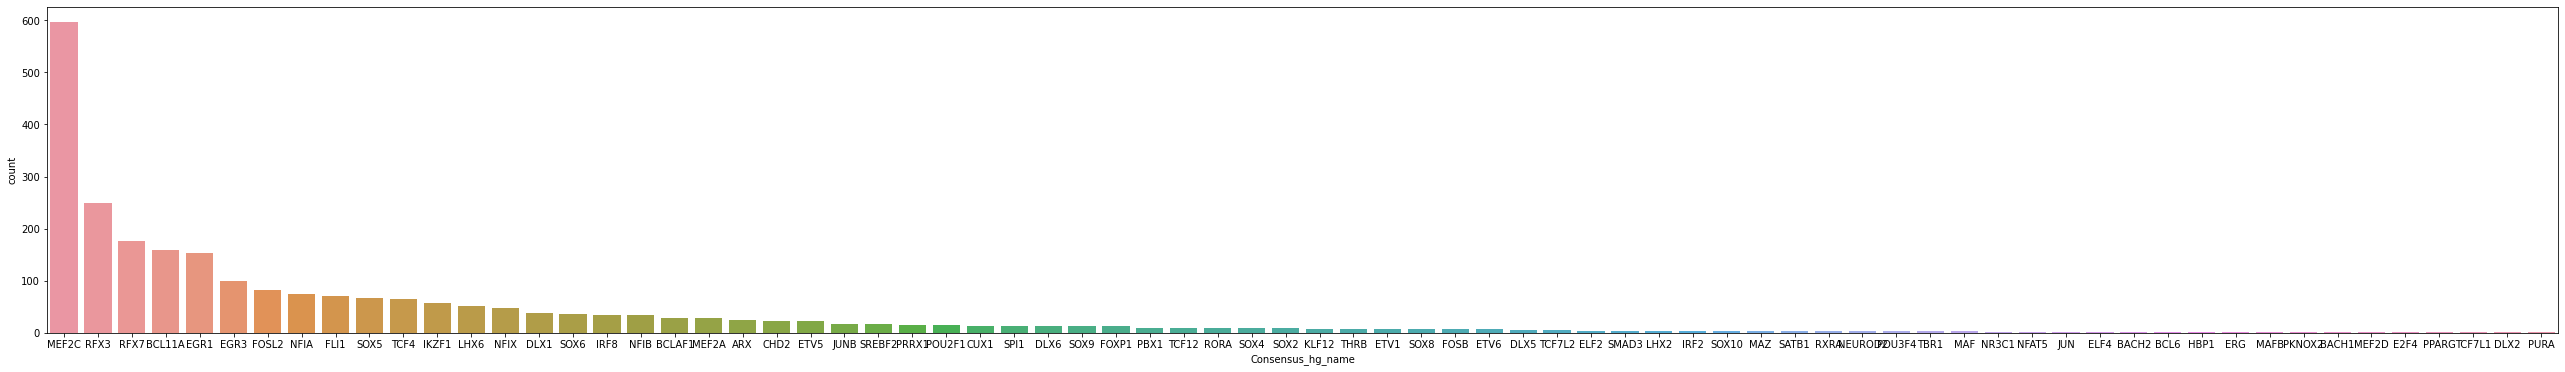

In [51]:
import seaborn
from matplotlib import pyplot
a4_dims = (45, 6)
fig, ax = pyplot.subplots(figsize=a4_dims)
seaborn.countplot(x='Consensus_hg_name', data=same_tf, order=same_tf['Consensus_hg_name'].value_counts().index)


In [48]:
mouse_coords.df.iloc[:,0:3].drop_duplicates()

,Chromosome,Start,End
0,chr1,3119647,3120147
1,chr1,3120206,3120706
2,chr1,3121454,3121954
4,chr1,3299631,3300131
5,chr1,3324225,3324725
...,...,...,...
204040,chrX,169333485,169333985
204041,chrX,169811321,169811821
204042,chrX,169813604,169814104
204043,chrX,169826874,169827374


In [47]:
combined.iloc[:,0:3].drop_duplicates()

,Chromosome,Start,End
0,chr1,5017896,5018396
4,chr1,5019213,5019713
10,chr1,5019867,5020367
18,chr1,5020390,5020890
22,chr1,5022791,5023291
...,...,...,...
102446,chrX,167277004,167277504
102447,chrX,167497732,167498232
102450,chrX,167828350,167828850
102451,chrX,168123118,168123618


In [113]:
import numpy as np
def region_names_to_coordinates(region_names):
    chrom = pd.DataFrame([i.split(':', 1)[0] if ':' in i else float("nan") for i in region_names ])
    coor = [i.split(':', 1)[1] if ':' in i else float("nan") for i in region_names]
    start = pd.DataFrame([int(i.split('-', 1)[0]) if type(i) == str else float("nan") for i in coor])
    end = pd.DataFrame([int(i.split('-', 1)[1]) if type(i) == str else float("nan") for i in coor])
    regiondf = pd.concat([chrom, start, end], axis=1, sort=False)
    regiondf.index = [i if ':' in i else float("nan") for i in region_names]
    regiondf.columns = ['Chromosome', 'Start', 'End']
    return (regiondf)

In [115]:
# Compare with microglia library
mgl_cheqseq = pd.read_csv('/staging/leuven/stg_00002/lcb/cbravo/brain_mpra/CHEQ-seq_library/selected/human_mouse_sequences_259bp.bed', sep='\t')
#from pycisTopic.utils import region_names_to_coordinates
mm10_coords = region_names_to_coordinates([x.split('__')[3] for x in mgl_cheqseq.iloc[:,3]])
mm10_coords['CHEQ-seq'] = mgl_cheqseq.iloc[:,3].tolist()
mm10_coords.dropna(axis = 0, how = 'any', inplace = True)
mm10_coords = pr.PyRanges(mm10_coords)

In [116]:
mm10_coords

,Chromosome,Start,End,CHEQ-seq
0,chr1,132341672,132342172,hg38__chr1:205288041-205288541__mm10__chr1:132...
1,chr1,138039125,138039625,hg38__chr1:198776593-198777093__mm10__chr1:138...
2,chr1,62721287,62721787,hg38__chr2:205700197-205700697__mm10__chr1:627...
3,chr1,87620077,87620577,hg38__chr2:233059955-233060455__mm10__chr1:876...
4,chr1,54798369,54798869,hg38__chr2:197152326-197152826__mm10__chr1:547...
...,...,...,...,...
1944,chrX,65601639,65602139,mm10__chrX:96025834-96026334__hg38__chrX:65601...
1945,chrX,12950883,12951383,mm10__chrX:167229203-167229703__hg38__chrX:129...
1946,chrX,49041525,49042025,mm10__chrX:7763925-7764425__hg38__chrX:4904152...
1947,chrX,130110424,130110924,mm10__chrX:48454051-48454551__hg38__chrX:13011...


In [117]:
combined_mm = pr.PyRanges(combined[['Chromosome', 'Start', 'End', 'Name', 'Consensus_mm_name']])

In [118]:
mgl_scenic = mm10_coords.join(combined_mm)

In [119]:
mgl_scenic.df.drop_duplicates()

,Chromosome,Start,End,CHEQ-seq,Start_b,End_b,Name,Consensus_mm_name
0,chr1,171388736,171389236,hg38__chr1:161069672-161070172__mm10__chr1:171...,171388730,171389230,Runx1_extended_+_+,RUNX1
3,chr1,171388736,171389236,hg38__chr1:161069672-161070172__mm10__chr1:171...,171388730,171389230,Ikzf1_extended_+_+,IKZF1
6,chr1,171388736,171389236,hg38__chr1:161069672-161070172__mm10__chr1:171...,171388730,171389230,Irf8_+_+,IRF8
9,chr1,171388736,171389236,hg38__chr1:161069672-161070172__mm10__chr1:171...,171388730,171389230,Spi1_+_+,SPI1
12,chr1,171388736,171389236,hg38__chr1:161069672-161070172__mm10__chr1:171...,171388730,171389230,Elf4_+_+,ELF4
...,...,...,...,...,...,...,...,...
4289,chrX,96025834,96026334,hg38__chrX:65601639-65602139__mm10__chrX:96025...,96025778,96026278,Spi1_+_+,SPI1
4290,chrX,96025834,96026334,hg38__chrX:65601639-65602139__mm10__chrX:96025...,96025778,96026278,Elf4_+_+,ELF4
4291,chrX,96025834,96026334,hg38__chrX:65601639-65602139__mm10__chrX:96025...,96025778,96026278,Etv5_+_-,ETV5
4292,chrX,96025834,96026334,hg38__chrX:65601639-65602139__mm10__chrX:96025...,96025778,96026278,Fli1_+_+,FLI1


In [149]:
FIRE='hg38__chr5:150081847-150082347__mm10__chr18:61108316-61108816'
set(mgl_scenic.df[mgl_scenic.df['CHEQ-seq'] == FIRE].Name)

{'Bcl11a_extended_+_+',
 'Elf4_+_+',
 'Elk3_+_+',
 'Ets1_+_+',
 'Etv6_+_+',
 'Fli1_+_+',
 'Ikzf1_extended_+_+',
 'Irf2_+_+',
 'Irf5_+_+',
 'Irf8_+_+',
 'Nf1_extended_-_+',
 'Smad3_+_+',
 'Spi1_+_+',
 'Zfp148_+_+'}

In [130]:
mgl_scenic.df.drop_duplicates().Consensus_mm_name.value_counts()[0:30]

FLI1      88
IKZF1     80
BCL11A    77
EP300     71
SPI1      67
ELK3      56
ELF4      50
IRF8      46
IRF5      43
ZFP148    41
IRF2      32
ETS1      29
ETV6      27
ZBTB11    25
ETV5      24
BCLAF1    16
TCF12     13
RUNX1     13
NF1       12
MEF2C     11
ATF2       9
JUNB       8
POU2F1     8
IKZF2      8
ELK1       8
ETV1       8
STAT6      8
ETV3       8
MAZ        7
ELF2       7
Name: Consensus_mm_name, dtype: int64

In [138]:
mgl_scenic.df.drop_duplicates().to_csv('/staging/leuven/stg_00002/lcb/cbravo/brain_mpra/CHEQ-seq_library/selected/MGL_CHEQseq_conserved_eGRN_v1.bed', sep='\t')

In [129]:
mgl_scenic.df.iloc[:,0:3].drop_duplicates()

,Chromosome,Start,End
0,chr1,171388736,171389236
21,chr1,58802281,58802781
45,chr1,131199983,131200483
57,chr1,165707894,165708394
137,chr1,180942718,180943218
...,...,...,...
4239,chr18,80704728,80705228
4244,chr19,41384308,41384808
4246,chr19,5711862,5712362
4267,chr19,10842198,10842698


In [150]:
def load_motif_annotations(specie: str,
                           version: str = 'v9',
                           fname: str = None,
                           column_names=('#motif_id', 'gene_name',
                                         'motif_similarity_qvalue', 'orthologous_identity', 'description'),
                           motif_similarity_fdr: float = 0.001,
                           orthologous_identity_threshold: float = 0.0):
    """
    Load motif annotations from a motif2TF snapshot.
    
    Parameters
    ---------
    specie:
        Specie to retrieve annotations for.
    version:
        Motif collection version.
    fname: 
        The snapshot taken from motif2TF.
    column_names: 
        The names of the columns in the snapshot to load.
    motif_similarity_fdr: 
        The maximum False Discovery Rate to find factor annotations for enriched motifs.
    orthologuous_identity_threshold: 
        The minimum orthologuous identity to find factor annotations for enriched motifs.
    
    Return
    ---------
        A dataframe with motif annotations for each motif
    """
    # Create a MultiIndex for the index combining unique gene name and motif ID. This should facilitate
    # later merging.
    if fname is None:
        if specie == 'mus_musculus':
            name='mgi'
        elif specie == 'homo_sapiens':
            name='hgnc'
        elif specie == 'drosophila_melanogaster':
            name='flybase'
        fname = 'https://resources.aertslab.org/cistarget/motif2tf/motifs-'+version+'-nr.'+name+'-m0.001-o0.0.tbl'
    df = pd.read_csv(fname, sep='\t', usecols=column_names)
    df.rename(columns={'#motif_id':"MotifID",
                       'gene_name':"TF",
                       'motif_similarity_qvalue': "MotifSimilarityQvalue",
                       'orthologous_identity': "OrthologousIdentity",
                       'description': "Annotation" }, inplace=True)
    df = df[(df["MotifSimilarityQvalue"] <= motif_similarity_fdr) &
            (df["OrthologousIdentity"] >= orthologous_identity_threshold)]
    
    # Direct annotation
    df_direct_annot = df[df['Annotation'] == 'gene is directly annotated']
    df_direct_annot = df_direct_annot.groupby(['MotifID'])['TF'].apply(lambda x: ', '.join(list(set(x)))).reset_index()
    df_direct_annot.index = df_direct_annot['MotifID']
    df_direct_annot = pd.DataFrame(df_direct_annot['TF'])
    df_direct_annot.columns = ['Direct_annot']
    # Indirect annotation - by motif similarity
    motif_similarity_annot = df[df['Annotation'].str.contains('similar') & ~df['Annotation'].str.contains('orthologous')]
    motif_similarity_annot = motif_similarity_annot.groupby(['MotifID'])['TF'].apply(lambda x: ', '.join(list(set(x)))).reset_index()
    motif_similarity_annot.index =  motif_similarity_annot['MotifID']
    motif_similarity_annot = pd.DataFrame(motif_similarity_annot['TF'])
    motif_similarity_annot.columns = ['Motif_similarity_annot']
    # Indirect annotation - by orthology
    orthology_annot = df[~df['Annotation'].str.contains('similar') & df['Annotation'].str.contains('orthologous')]
    orthology_annot = orthology_annot.groupby(['MotifID'])['TF'].apply(lambda x: ', '.join(list(set(x)))).reset_index()
    orthology_annot.index = orthology_annot['MotifID']
    orthology_annot = pd.DataFrame(orthology_annot['TF'])
    orthology_annot.columns = ['Orthology_annot']
    # Indirect annotation - by orthology
    motif_similarity_and_orthology_annot = df[df['Annotation'].str.contains('similar') & df['Annotation'].str.contains('orthologous')]
    motif_similarity_and_orthology_annot = motif_similarity_and_orthology_annot.groupby(['MotifID'])['TF'].apply(lambda x: ', '.join(list(set(x)))).reset_index()
    motif_similarity_and_orthology_annot.index = motif_similarity_and_orthology_annot['MotifID']
    motif_similarity_and_orthology_annot = pd.DataFrame(motif_similarity_and_orthology_annot['TF'])
    motif_similarity_and_orthology_annot.columns = ['Motif_similarity_and_Orthology_annot']
    # Combine
    df = pd.concat([df_direct_annot, motif_similarity_annot, orthology_annot, motif_similarity_and_orthology_annot], axis=1, sort=False)
    return df
    

In [276]:
df_old = load_motif_annotations(specie = 'mus_musculus',
                           version = 'v10nr_clust',
                           fname = '/staging/leuven/stg_00002/lcb/icistarget/data/motif2tf_project/motif_to_tf_db_data/snapshots/motifs-v10-nr.mgi-m0.000000000001-o0.0.tbl',
                           column_names=('#motif_id', 'gene_name',
                                         'motif_similarity_qvalue', 'orthologous_identity', 'description'),
                           motif_similarity_fdr = 1,
                           orthologous_identity_threshold = 0.0)

In [277]:
df_old['Direct_annot'].dropna().shape[0]

5711

In [278]:
df_old['Orthology_annot'].dropna().shape[0]

16424

In [279]:
df_old['Motif_similarity_and_Orthology_annot'].dropna().shape[0]

5824

In [280]:
df_old['Motif_similarity_annot'].dropna().shape[0]

3499

In [281]:
direct=set(df_old['Direct_annot'].dropna().drop_duplicates().index.tolist())
orth=set(df_old['Orthology_annot'].dropna().drop_duplicates().index.tolist())
print(len(direct))
print(len(orth))
len(set(list(direct)+list(orth)))

1032
1955


2959

In [301]:
df_old = load_motif_annotations(specie = 'mus_musculus',
                           version = 'v10nr_clust',
                           fname = '/staging/leuven/stg_00002/lcb/icistarget/data/motif2tf_project/motif_to_tf_db_data/snapshots/motifs-v10-nr.mgi-m0.000001-o0.0.tbl',
                           column_names=('#motif_id', 'gene_name',
                                         'motif_similarity_qvalue', 'orthologous_identity', 'description'),
                           motif_similarity_fdr = 1,
                           orthologous_identity_threshold = 0.0)

In [302]:
df_old['Direct_annot'].dropna().shape[0]

5711

In [303]:
df_old['Orthology_annot'].dropna().shape[0]

16424

In [304]:
df_old['Motif_similarity_and_Orthology_annot'].dropna().shape[0]

13682

In [305]:
df_old['Motif_similarity_annot'].dropna().shape[0]

10342

In [306]:
x = df_old['Direct_annot'].dropna()
direct=set(x.index.tolist())
x = df_old['Orthology_annot'].dropna()
orth=set(x.dropna().index.tolist())
print(len(direct))
print(len(orth))
len(set(list(direct)+list(orth)))

5711
16424


22038

In [375]:
df_old = load_motif_annotations(specie = 'drosophila_melanogaster',
                           version = 'v10nr_clust',
                           fname = '/staging/leuven/stg_00002/lcb/cbravo/cluster_motif_collection_V10/snapshots/motifs-v10-nr.flybase-mm0.00001-o0.0_clust.tsv',
                           column_names=('#motif_id', 'gene_name',
                                         'motif_similarity_qvalue', 'orthologous_identity', 'description'),
                           motif_similarity_fdr = 0.001,
                           orthologous_identity_threshold = 0.0)

In [377]:
df_old

,Direct_annot,Motif_similarity_annot,Orthology_annot,Motif_similarity_and_Orthology_annot
MotifID,,,,
bergman__Abd-B,Abd-B,NaN,NaN,NaN
bergman__Adf1,Adf1,NaN,NaN,NaN
bergman__Aef1,Aef1,NaN,NaN,NaN
bergman__Dip3,Dlip3,NaN,NaN,NaN
bergman__Dref,Dref,NaN,NaN,NaN
...,...,...,...,...
transfac_public__M00108,NaN,NaN,NaN,Ets97D
transfac_public__M00291,NaN,NaN,NaN,fkh
transfac_public__M00378,NaN,NaN,NaN,pnr


In [378]:
df_old['Direct_annot'].dropna().shape[0]

2637

In [379]:
df_old['Orthology_annot'].dropna().shape[0]

1478

In [380]:
x = df_old['Direct_annot'].dropna()
direct=set(x.index.tolist())
x = df_old['Orthology_annot'].dropna()
orth=set(x.dropna().index.tolist())
print(len(direct))
print(len(orth))
len(set(list(direct)+list(orth)))

2637
1478


4047

In [381]:
len(direct)

2637

In [382]:
len(orth)

1478

In [383]:
len(set(list(direct)+list(orth)))

4047

In [384]:
motifs = pd.read_csv('/staging/leuven/stg_00002/lcb/cbravo/cluster_motif_collection_V10/motifs.txt', header=None)

In [385]:
motifs_wannot = list(set(list(direct)+list(orth)))

In [386]:
ov = [x for x in motifs_wannot if x in motifs.iloc[:,0].tolist()]
nov = [x for x in motifs_wannot if x not in motifs.iloc[:,0].tolist()]

In [387]:
len(ov)

1388

In [388]:
len(nov)

2659

In [389]:
m=motifs.iloc[:,0].tolist()

In [391]:
df_old = load_motif_annotations(specie = 'drosophila_melanogaster',
                           version = 'v10nr_clust',
                           fname = '/staging/leuven/stg_00002/lcb/cbravo/cluster_motif_collection_V10/snapshots/motifs-v10-nr.flybase-m0.001-o0.0_clust.tsv',
                           column_names=('#motif_id', 'gene_name',
                                         'motif_similarity_qvalue', 'orthologous_identity', 'description'),
                           motif_similarity_fdr = 0.001,
                           orthologous_identity_threshold = 0.0)

In [392]:
df_old

,Direct_annot,Motif_similarity_annot,Orthology_annot,Motif_similarity_and_Orthology_annot
MotifID,,,,
bergman__Abd-B,Abd-B,NaN,NaN,NaN
bergman__Adf1,Adf1,NaN,NaN,NaN
bergman__Aef1,Aef1,NaN,NaN,NaN
bergman__Dip3,Dlip3,NaN,NaN,NaN
bergman__Dref,Dref,NaN,NaN,NaN
...,...,...,...,...
tfdimers__MD00572,NaN,NaN,NaN,FoxL1
tfdimers__MD00576,NaN,NaN,NaN,"nau, Max"
tfdimers__MD00577,NaN,NaN,NaN,"Taf6, Stat92E"


In [393]:
df_old['Direct_annot'].dropna().shape[0]

2637

In [394]:
df_old['Orthology_annot'].dropna().shape[0]

1478

In [395]:
x = df_old['Direct_annot'].dropna()
direct=set(x.index.tolist())
x = df_old['Orthology_annot'].dropna()
orth=set(x.dropna().index.tolist())
print(len(direct))
print(len(orth))
len(set(list(direct)+list(orth)))

2637
1478


4047

In [396]:
len(direct)

2637

In [397]:
len(orth)

1478

In [398]:
len(set(list(direct)+list(orth)))

4047

In [399]:
motifs = pd.read_csv('/staging/leuven/stg_00002/lcb/cbravo/cluster_motif_collection_V10/motifs.txt', header=None)

In [400]:
motifs_wannot = list(set(list(direct)+list(orth)))

In [401]:
ov = [x for x in motifs_wannot if x in motifs.iloc[:,0].tolist()]
nov = [x for x in motifs_wannot if x not in motifs.iloc[:,0].tolist()]

In [402]:
len(ov)

1388

In [403]:
len(nov)

2659

In [404]:
m=motifs.iloc[:,0].tolist()

In [406]:
# Motifs with no annotation
df_old = load_motif_annotations(specie = 'mus_musculus',
                           version = 'v10nr_clust',
                           fname = '/staging/leuven/stg_00002/lcb/cbravo/cluster_motif_collection_V10/snapshots/motifs-v10-nr.mgi-m0.001-o0.0_clust.tsv',
                           column_names=('#motif_id', 'gene_name',
                                         'motif_similarity_qvalue', 'orthologous_identity', 'description'),
                           motif_similarity_fdr = 1,
                           orthologous_identity_threshold = 0.0)

In [407]:
x = df_old['Direct_annot'].dropna()
direct=set(x.index.tolist())
x = df_old['Orthology_annot'].dropna()
orth=set(x.dropna().index.tolist())
print(len(direct))
print(len(orth))
len(set(list(direct)+list(orth)))

4325
12490


16408

In [422]:
motifs = pd.read_csv('/staging/leuven/stg_00002/lcb/cbravo/cluster_motif_collection_V10/motifs.txt', header=None)

In [423]:
motifs_wannot = list(set(list(direct)+list(orth)))

['transfac_pro__M04636',
 'swissregulon__rn__Trp73',
 'metacluster_96.3',
 'swissregulon__mm__Pknox2',
 'cisbp__M10491',
 'transfac_pro__M11882',
 'cisbp__M09143',
 'cisbp__M03961',
 'kznf__KLF1_Barrera2016.1_PBM',
 'metacluster_154.13',
 'cisbp__M04768',
 'transfac_pro__M01303',
 'cisbp__M03213',
 'transfac_pro__M04482',
 'cisbp__M11376',
 'transfac_pro__M03922',
 'cisbp__M07868',
 'flyfactorsurvey__pho_FlyReg_FBgn0002521',
 'cisbp__M00366',
 'transfac_pro__M11488',
 'taipale_tf_pairs__FLI1_BHLHA15_NCCGGAANCATATGN_CAP',
 'transfac_pro__M09949',
 'cisbp__M08978',
 'cisbp__M08918',
 'cisbp__M09112',
 'taipale__Rfx2_DBD_SGTTGCYARGCAACS_repr',
 'cisbp__M09403',
 'metacluster_99.3B',
 'cisbp__M05503',
 'transfac_pro__M00482',
 'transfac_pro__M11609',
 'transfac_pro__M08541',
 'cisbp__M03385',
 'cisbp__M05145',
 'cisbp__M04149',
 'cisbp__M10753',
 'swissregulon__hs__VSX2',
 'transfac_pro__M05423',
 'transfac_pro__M12544',
 'cisbp__M04142',
 'transfac_pro__M11388',
 'cisbp__M11429',
 'transf

In [424]:
nov = [x for x in motifs.iloc[:,0].tolist() if x not in motifs_wannot]

In [425]:
nov=pd.DataFrame(nov)

In [426]:
nov.to_csv('/staging/leuven/stg_00002/lcb/cbravo/cluster_motif_collection_V10/mm_not_annotated_DO.tsv', sep='\t')

In [427]:
len(nov)

10243